# Bayesian inversion of diffusivity in Poisson equation

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl

import pickle

import torch

from scipy.interpolate import griddata

model_path = "../../problems/poisson/"
sys.path.append(model_path)
from poissonModel import PoissonModel

src_path = "../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import *
from plot_mix_collection import *
from point_plot import *
from plot_curve import plot_curve

sys.path.append(src_path + 'prior')
from priorSampler import PriorSampler

sys.path.append(src_path + 'pde')
from fenicsUtilities import function_to_vertex

sys.path.append(src_path + 'mcmc')
from mcmc import MCMC
from mcmc_plot_fields import mcmc_plot_fields, mcmc_plot_fields_base
from compute_sample_errors import compute_sample_errors

sys.path.append(src_path + 'nn/deeponet')
sys.path.append(src_path + 'data/')
sys.path.append(src_path + 'nn/mlp')
from load_data_and_deeponet import load_data_and_deeponet

sys.path.append(src_path + 'nn/pcanet')
from load_data_and_pcanet import load_data_and_pcanet

sys.path.append(src_path + 'nn/fno')
from load_data_and_fno import load_data_and_fno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [2]:
model_data_folder = model_path + 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create PoissonModel

In [3]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 1
prior_logn_translate = 0.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'Poisson'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = Vm

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

# create model
model = PoissonModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

# Load Neural Operators

In [4]:
class SurrogateModel:
    def __init__(self, true_model, model, data):
        self.true_model = true_model
        self.model = model
        self.data = data
        self.model_type = self.model.name
        self.w_to_m = None
        self.u = None

    def solveFwd(self, w):
        if self.model_type == 'DeepONet':
            self.w_to_m = self.true_model.transform_gaussian_pointwise(w)
            self.u = self.data.decoder_Y(self.model.predict(self.data.encoder_X(self.w_to_m), self.data.X_trunk).detach().numpy())
        elif self.model_type == 'PCANet':
            self.w_to_m = self.true_model.transform_gaussian_pointwise(w)
            self.u = self.data.decoder_Y(self.model.predict(self.data.encoder_X(self.w_to_m)).detach().numpy())
        else:
            raise Exception('Unknown model type')

        return self.u

In [5]:
def load_deeponet():
    data_path = model_path + 'data/' + 'Poisson_samples.npz'
    nn_path = model_path + 'DeepONet/Results/model.pkl'
    data, nn = load_data_and_deeponet(data_path, nn_path)
    nn_surrogate = SurrogateModel(model, nn, data)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

deeponet = load_deeponet()

nn_data:  <dataMethods.DataProcessor object at 0x7fe60c946650>
nn_model:  DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2601, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
)


In [6]:
def load_pcanet():
    data_path = model_path + 'data/' + 'Poisson_samples.npz'
    nn_path = model_path + 'PCANet/Results/model.pkl'
    data, nn = load_data_and_pcanet(data_path, nn_path)
    nn_surrogate = SurrogateModel(model, nn, data)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

pcanet = load_pcanet()

nn_data:  <dataMethods.DataProcessor object at 0x7fe413aa3cd0>
nn_model:  PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=100, bias=True)
    )
  )
)


In [7]:
def load_fno():
    data_path = model_path + 'data/' + 'Poisson_FNO_samples.npz'
    nn_path = model_path + 'FNO/Results/model.pkl'
    data, nn = load_data_and_fno(data_path, nn_path)
    nn_surrogate = SurrogateModel(model, nn, data)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return nn_surrogate

fno = load_fno()

nn_data:  <dataMethods.DataProcessorFNO object at 0x7fe60ddf6310>
nn_model:  FNO2D(
  (fno_layers): ModuleList(
    (0-2): 3 x FNO2DLayer(
      (w): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (input_projector): Linear(in_features=3, out_features=20, bias=True)
  (output_projector): Linear(in_features=20, out_features=1, bias=True)
)


In [8]:
surrogate_models = {'DeepONet': deeponet, 'PCANet': pcanet, 'FNO': fno}

In [9]:
t1 = time.time()
m1 = model.samplePrior(transform_m = True)
m2 = m1.copy()
t2 = time.time()
print('Time to sample m: ', t2 - t1)

# Poisson model solver
t1 = time.time()
u_model = model.solveFwd(u = None, m = m2, transform_m = False)
t2 = time.time()
print('Time to solve Poisson model forward: ', t2 - t1)

# neural operators
sm_use = ['DeepONet', 'PCANet']
for sm in sm_use:
    t1 = time.time()
    u_sm = surrogate_models[sm].solveFwd(m2)
    t2 = time.time()
    print('Time to solve {} forward: '.format(surrogate_models[sm].model_type), t2 - t1)

Time to sample m:  0.05006861686706543
Time to solve Poisson model forward:  0.056392669677734375
Time to solve DeepONet forward:  0.054149627685546875
Time to solve PCANet forward:  0.003023862838745117


# Get ground truth

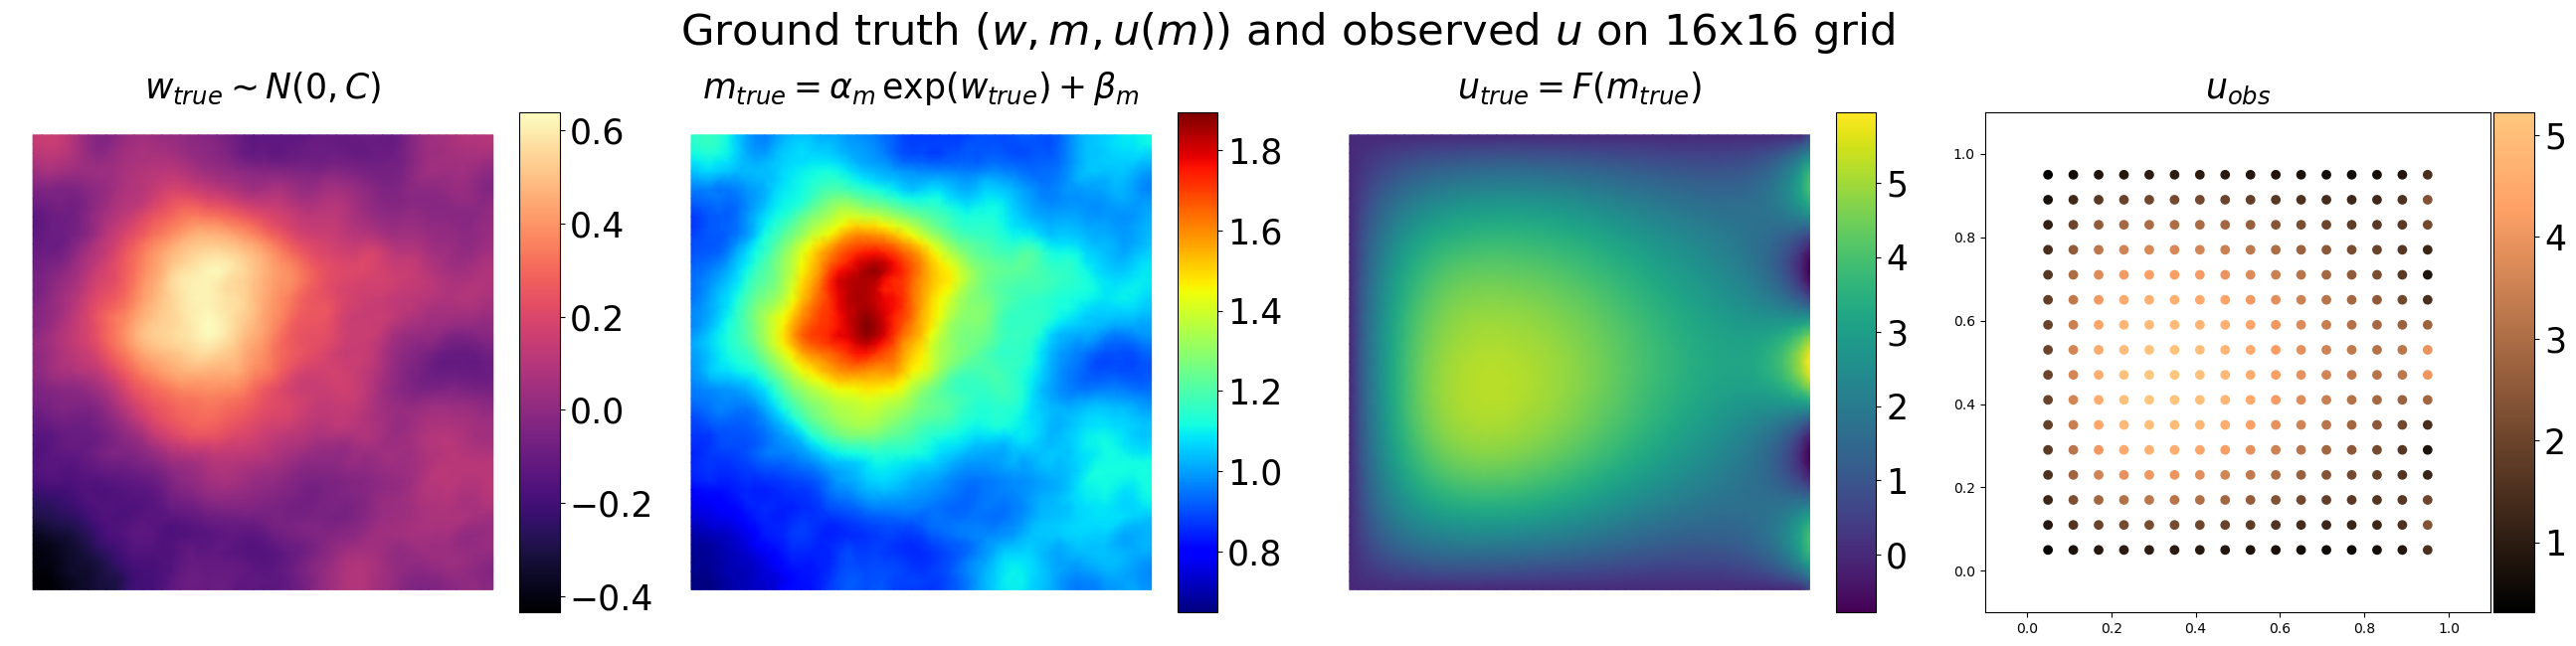

In [10]:
# load
ground_truth_data = np.load(results_dir + 'ground_truth/data.npz')
num_grid_x, num_grid_y = ground_truth_data['num_grid_x'], ground_truth_data['num_grid_y']
w_true = ground_truth_data['w_true']
m_true = ground_truth_data['m_true']
u_true = ground_truth_data['u_true']
x_obs = ground_truth_data['x_obs']
u_obs = ground_truth_data['u_obs']


rows, cols = 1, 4
fig, axs = plt.subplots(rows, cols, figsize=(26, 6))
axs = np.array([axs]) if rows == 1 else axs

uvec = [[w_true, m_true, u_true]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$', r'$u_{obs}$']]
cmap_vec = [['magma', 'jet', 'viridis', 'copper']]
sup_title = r'Ground truth $(w, m, u(m))$ and observed $u$ on {}x{} grid'.format(num_grid_x, num_grid_y)
fs = 25
y_sup_title = 1.075
savefilename = results_dir + 'true_and_obs_w_m_u.png'

nodes = model.Vm.mesh().coordinates()


for i in range(rows):
    for j in range(cols):

        # add grid points
        if j == cols - 1:
            axs[i,j].set_xlim([-0.1, 1.1])
            axs[i,j].set_ylim([-0.1, 1.1])
        
        if j < cols - 1:
            cbar = field_plot(axs[i,j], \
                uvec[i][j], \
                nodes, cmap = cmap_vec[i][j])
        else:
            cbar = point_plot(axs[i,j], u_obs, x_obs, cmap = cmap_vec[i][j])
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        if j < cols - 1:
            axs[i,j].axis('off')
        if title_vec is not None:
            axs[i,j].set_title(title_vec[i][j], fontsize=fs, pad=10)        

fig.tight_layout()
if sup_title is not None:
    fig.suptitle(sup_title, fontsize=1.25*fs, y = y_sup_title)
if savefilename is not None:
    plt.savefig(savefilename,  bbox_inches='tight')
plt.show()

## Compute noise

In [11]:
u_obs_mean, u_obs_std = np.mean(u_obs), np.std(u_obs)
sigma_noise = 0.05 * u_obs_mean
print('u_obs_mean = {:.3e}, u_obs_std = {:.3e}, sigma_noise: {:.3e}'.format(u_obs_mean, u_obs_std, sigma_noise))

u_obs_mean = 2.785e+00, u_obs_std = 1.329e+00, sigma_noise: 1.393e-01


# Bayesian parameter estimation setup

In [12]:
surrogate_to_use = None

mcmc = MCMC(model, prior_sampler, ground_truth_data, \
            sigma_noise = sigma_noise, pcn_beta = 0.2, \
            surrogate_to_use = surrogate_to_use, \
            surrogate_models = surrogate_models, \
            seed = seed)

# display low-res files for testing
mcmc.pp_params = {'curve_plot': {'fs': 12, 'lw': 3, 'figsize': (4,3)}, \
                          'field_plot': {'fs': 10, 'y_sup_title': 1.025, 'figsize': (8, 6), 'ttl_pad': 5}}

--------------------------------------------------
MCMC started with 1000 samples and 100 burnin
PCN beta: 2.000e-01, sigma_noise: 1.393e-01
Model used for solving the forward problem: True Model
Tracer save path: test_mcmc_results_n_samples_1000_n_burnin_100_pcn_beta_0.200_sigma_1.393e-01
Tracer save filename: tracer
--------------------------------------------------
initializing the current state. Initial cost: 2.504e+03
--------------------------------------------------
Burnin:    0, Cost: 2.504e+03
--------------------------------------------------
--------------------------------------------------
Sample:  100, Accepted samples:    0, Acceptance Rate: 0.000e+00, Cost mean: 0.000e+00. 
Tracing 100 samples took 1.182e+01s
Error (%) in w: ||w - w_mean|| = 1.000e+02, ||w - w_sample|| = 1.000e+02
Error (%) in m: ||m - m_mean|| = 2.244e+01, ||m - m_sample|| = 2.244e+01
Error (%) in u: ||u - u_mean|| = 5.482e+00, ||u - u_sample|| = 5.482e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 5

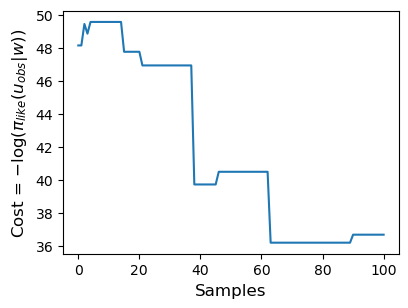

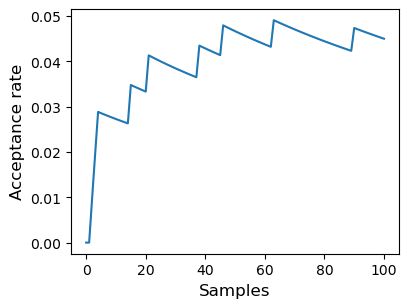

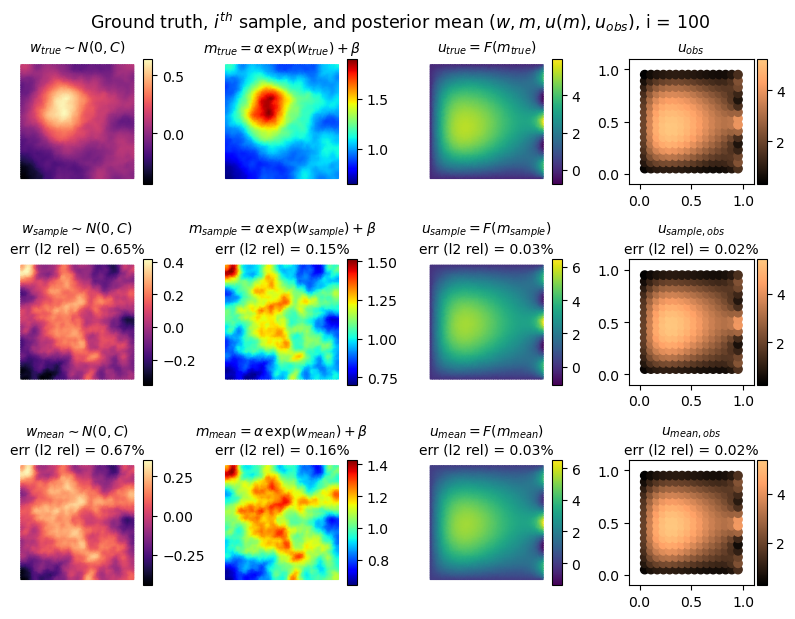

--------------------------------------------------
Sample:  300, Accepted samples:   12, Acceptance Rate: 4.000e-02, Cost mean: 3.713e+01. 
Tracing 100 samples took 1.653e+01s
Error (%) in w: ||w - w_mean|| = 6.222e+01, ||w - w_sample|| = 6.225e+01
Error (%) in m: ||m - m_mean|| = 1.468e+01, ||m - m_sample|| = 1.417e+01
Error (%) in u: ||u - u_mean|| = 2.428e+00, ||u - u_sample|| = 2.241e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.145e+00, ||u_obs - u_obs_sample|| = 2.166e+00
--------------------------------------------------
--------------------------------------------------
Sample:  400, Accepted samples:   18, Acceptance Rate: 4.500e-02, Cost mean: 3.196e+01. 
Tracing 100 samples took 1.218e+01s
Error (%) in w: ||w - w_mean|| = 5.723e+01, ||w - w_sample|| = 5.592e+01
Error (%) in m: ||m - m_mean|| = 1.351e+01, ||m - m_sample|| = 1.219e+01
Error (%) in u: ||u - u_mean|| = 2.003e+00, ||u - u_sample|| = 1.791e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.869e+00, ||u_obs - 

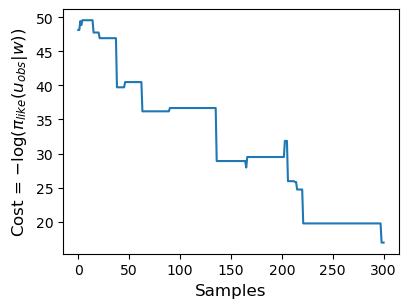

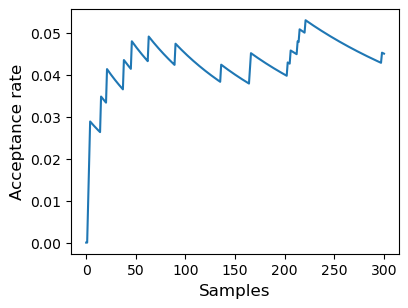

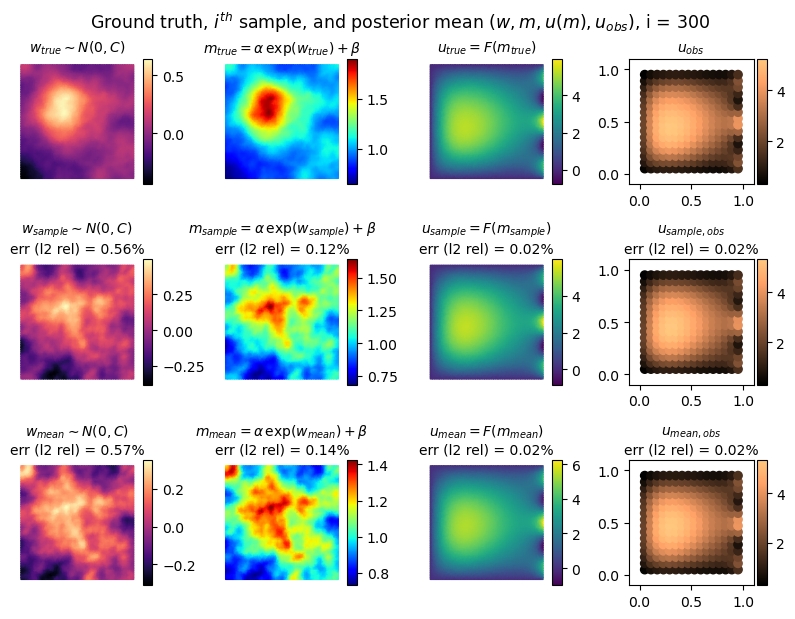

--------------------------------------------------
Sample:  500, Accepted samples:   20, Acceptance Rate: 4.000e-02, Cost mean: 2.808e+01. 
Tracing 100 samples took 1.569e+01s
Error (%) in w: ||w - w_mean|| = 5.457e+01, ||w - w_sample|| = 5.059e+01
Error (%) in m: ||m - m_mean|| = 1.276e+01, ||m - m_sample|| = 1.060e+01
Error (%) in u: ||u - u_mean|| = 1.771e+00, ||u - u_sample|| = 1.769e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.665e+00, ||u_obs - u_obs_sample|| = 1.577e+00
--------------------------------------------------
--------------------------------------------------
Sample:  600, Accepted samples:   23, Acceptance Rate: 3.833e-02, Cost mean: 2.547e+01. 
Tracing 100 samples took 1.232e+01s
Error (%) in w: ||w - w_mean|| = 5.226e+01, ||w - w_sample|| = 5.377e+01
Error (%) in m: ||m - m_mean|| = 1.205e+01, ||m - m_sample|| = 1.135e+01
Error (%) in u: ||u - u_mean|| = 1.645e+00, ||u - u_sample|| = 1.925e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.520e+00, ||u_obs - 

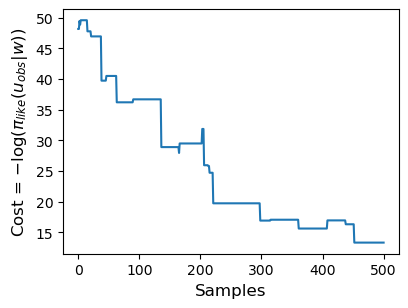

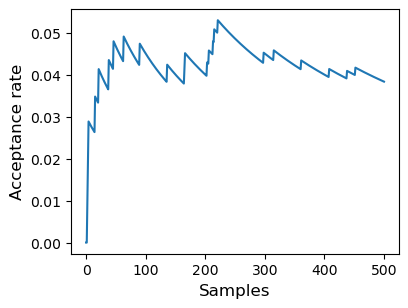

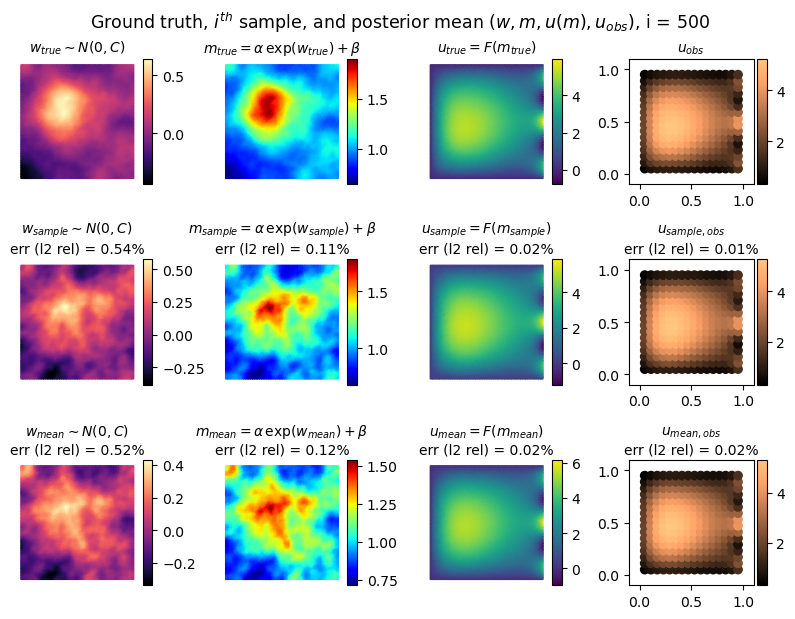

--------------------------------------------------
Sample:  700, Accepted samples:   23, Acceptance Rate: 3.286e-02, Cost mean: 2.342e+01. 
Tracing 100 samples took 1.586e+01s
Error (%) in w: ||w - w_mean|| = 5.103e+01, ||w - w_sample|| = 5.377e+01
Error (%) in m: ||m - m_mean|| = 1.163e+01, ||m - m_sample|| = 1.135e+01
Error (%) in u: ||u - u_mean|| = 1.604e+00, ||u - u_sample|| = 1.925e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.443e+00, ||u_obs - u_obs_sample|| = 1.457e+00
--------------------------------------------------
--------------------------------------------------
Sample:  800, Accepted samples:   24, Acceptance Rate: 3.000e-02, Cost mean: 2.196e+01. 
Tracing 100 samples took 1.185e+01s
Error (%) in w: ||w - w_mean|| = 5.052e+01, ||w - w_sample|| = 4.966e+01
Error (%) in m: ||m - m_mean|| = 1.140e+01, ||m - m_sample|| = 1.065e+01
Error (%) in u: ||u - u_mean|| = 1.597e+00, ||u - u_sample|| = 1.957e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.404e+00, ||u_obs - 

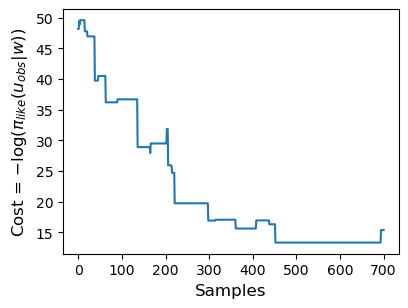

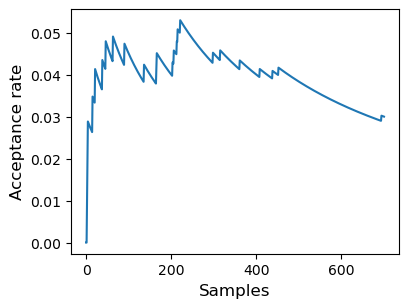

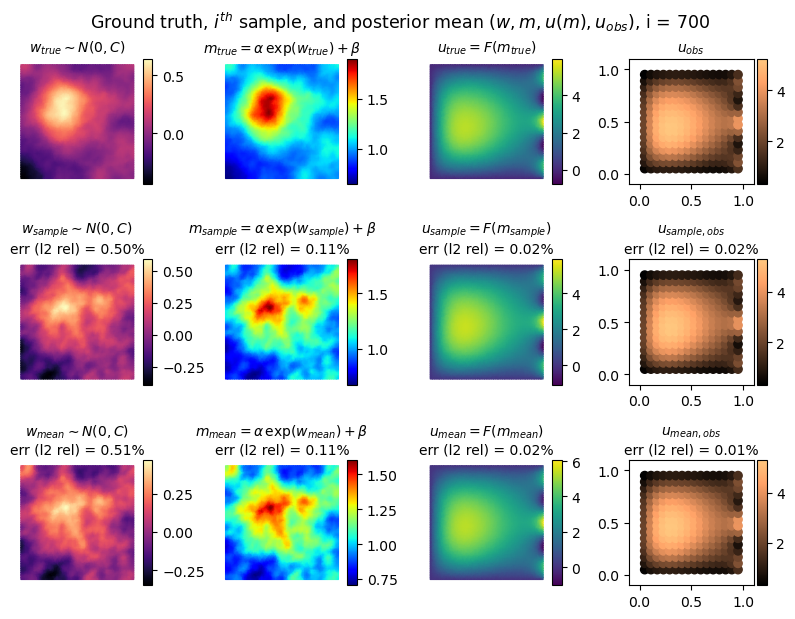

--------------------------------------------------
Sample:  900, Accepted samples:   27, Acceptance Rate: 3.000e-02, Cost mean: 2.098e+01. 
Tracing 100 samples took 1.570e+01s
Error (%) in w: ||w - w_mean|| = 4.962e+01, ||w - w_sample|| = 5.122e+01
Error (%) in m: ||m - m_mean|| = 1.116e+01, ||m - m_sample|| = 1.111e+01
Error (%) in u: ||u - u_mean|| = 1.584e+00, ||u - u_sample|| = 2.063e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.357e+00, ||u_obs - u_obs_sample|| = 1.526e+00
--------------------------------------------------
--------------------------------------------------
Sample: 1000, Accepted samples:   28, Acceptance Rate: 2.800e-02, Cost mean: 2.016e+01. 
Tracing 100 samples took 1.220e+01s
Error (%) in w: ||w - w_mean|| = 4.867e+01, ||w - w_sample|| = 4.662e+01
Error (%) in m: ||m - m_mean|| = 1.093e+01, ||m - m_sample|| = 1.014e+01
Error (%) in u: ||u - u_mean|| = 1.573e+00, ||u - u_sample|| = 1.795e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.332e+00, ||u_obs - 

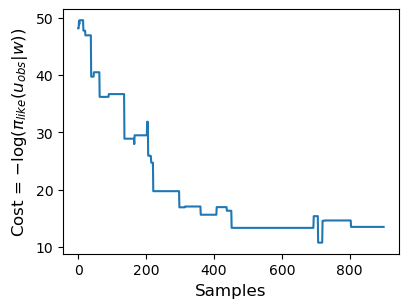

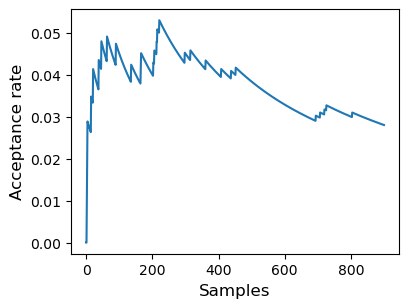

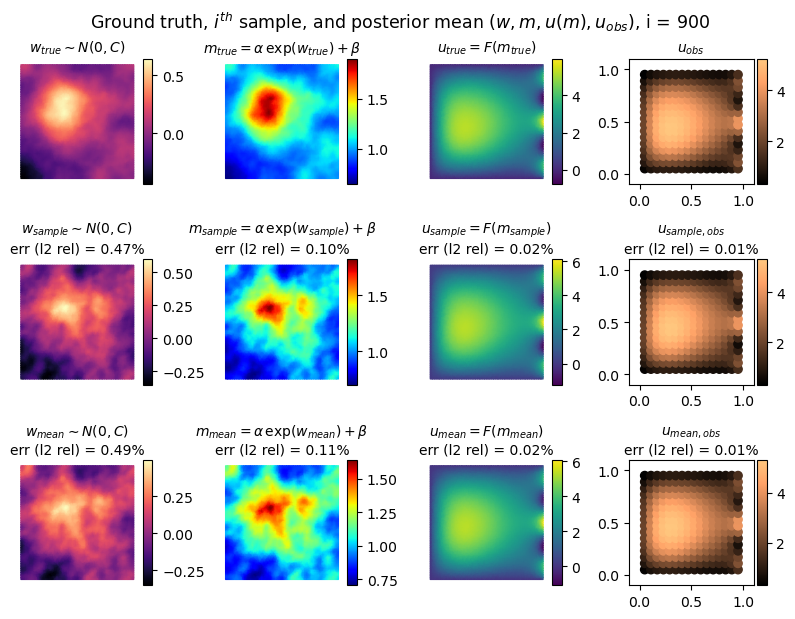

--------------------------------------------------
MCMC finished in 1.517e+02s. 
Total samples: 1100, Accepted samples:   28, Acceptance Rate: 2.545e-02, Cost mean: 1.949e+01
--------------------------------------------------


In [13]:
n_samples = 1000
n_burnin = 100
pcn_beta = 0.2
print_every = 100
display_plot_every = 2*print_every

mcmc.surrogate_to_use = None

savepath_base = results_dir + 'test_mcmc_results_n_samples_{:d}_n_burnin_{:d}_pcn_beta_{:.3f}_sigma_{:.3e}'.format(n_samples, n_burnin, pcn_beta, sigma_noise)

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         init_tracer = True, \
         savepath = savepath)

## Load tracer and plot

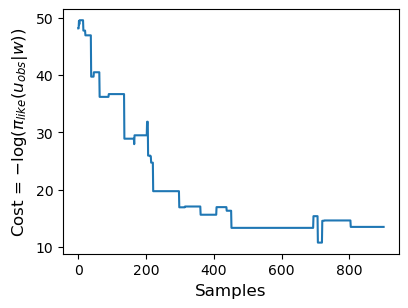

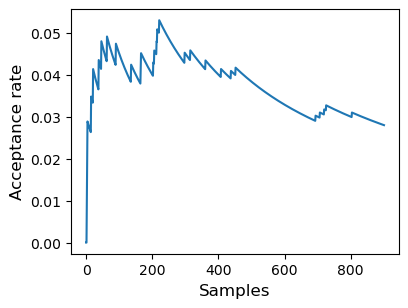

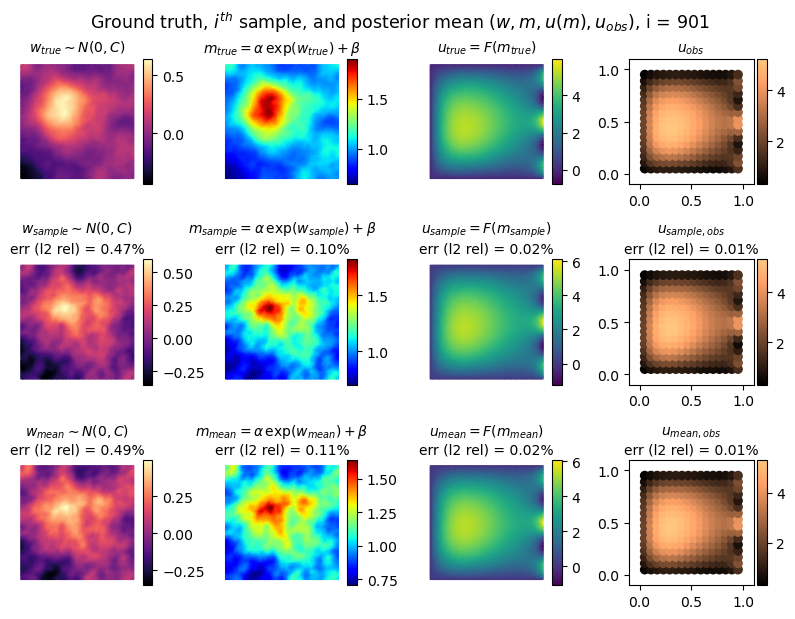

In [14]:
load_tracer = pickle.load(open(savepath + 'tracer' + '.pkl', 'rb'))

load_tracer.acceptances, load_tracer.current_acceptance_rate

savefig = False
pp_params = mcmc.pp_params['curve_plot']
plot_curve(load_tracer.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'])

plot_curve(load_tracer.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'])


w_mean = load_tracer.accepted_samples_mean_m
w_sample_i = len(load_tracer.accepted_samples_m) - 1
w_sample = load_tracer.accepted_samples_m[w_sample_i]

pp_params = mcmc.pp_params['field_plot']
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, savefilename = None, params = pp_params)

# Use surrogate and run the same problem

### DeepONet

--------------------------------------------------
MCMC started with 1000 samples and 100 burnin
PCN beta: 2.000e-01, sigma_noise: 1.393e-01
Model used for solving the forward problem: DeepONet
Tracer save path: test_mcmc_results_n_samples_1000_n_burnin_100_pcn_beta_0.200_sigma_1.393e-01_surrogate_DeepONet
Tracer save filename: tracer
--------------------------------------------------
initializing the current state. Initial cost: 1.372e+03
--------------------------------------------------
Burnin:    0, Cost: 1.372e+03
--------------------------------------------------
--------------------------------------------------
Sample:  100, Accepted samples:    0, Acceptance Rate: 0.000e+00, Cost mean: 0.000e+00. 
Tracing 100 samples took 2.318e+01s
Error (%) in w: ||w - w_mean|| = 1.000e+02, ||w - w_sample|| = 1.000e+02
Error (%) in m: ||m - m_mean|| = 2.244e+01, ||m - m_sample|| = 2.244e+01
Error (%) in u: ||u - u_mean|| = 5.482e+00, ||u - u_sample|| = 5.482e+00
Error (%) in u_obs: ||u_obs -

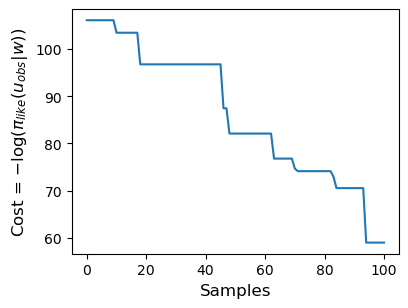

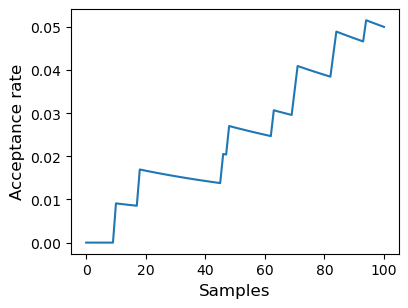

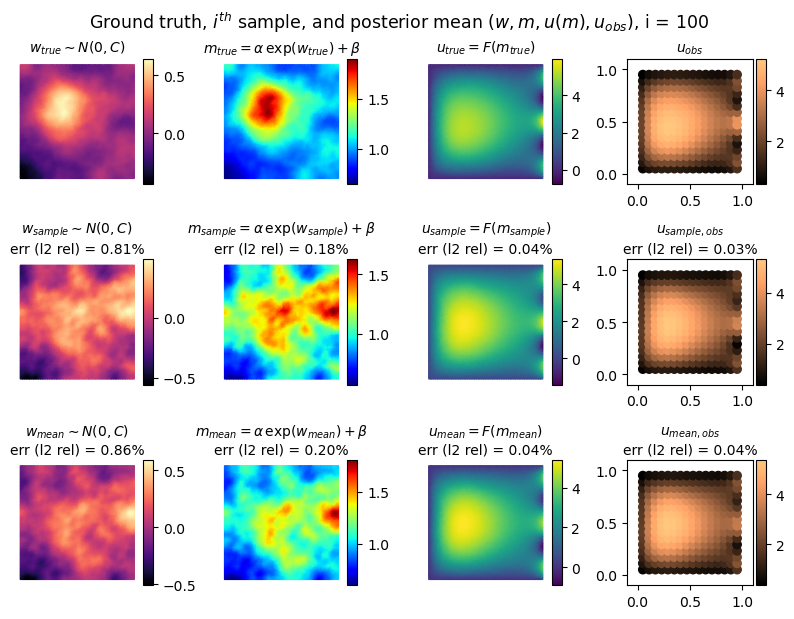

--------------------------------------------------
Sample:  300, Accepted samples:   16, Acceptance Rate: 5.333e-02, Cost mean: 7.315e+01. 
Tracing 100 samples took 3.044e+01s
Error (%) in w: ||w - w_mean|| = 8.205e+01, ||w - w_sample|| = 6.860e+01
Error (%) in m: ||m - m_mean|| = 1.866e+01, ||m - m_sample|| = 1.499e+01
Error (%) in u: ||u - u_mean|| = 4.136e+00, ||u - u_sample|| = 3.624e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 3.230e+00, ||u_obs - u_obs_sample|| = 2.703e+00
--------------------------------------------------
--------------------------------------------------
Sample:  400, Accepted samples:   22, Acceptance Rate: 5.500e-02, Cost mean: 6.032e+01. 
Tracing 100 samples took 2.495e+01s
Error (%) in w: ||w - w_mean|| = 7.321e+01, ||w - w_sample|| = 5.658e+01
Error (%) in m: ||m - m_mean|| = 1.653e+01, ||m - m_sample|| = 1.184e+01
Error (%) in u: ||u - u_mean|| = 3.613e+00, ||u - u_sample|| = 2.296e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.781e+00, ||u_obs - 

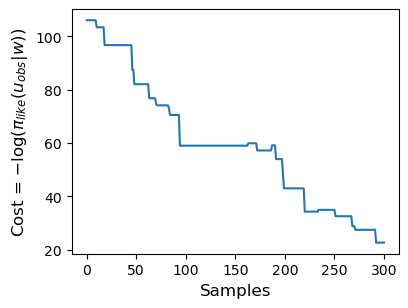

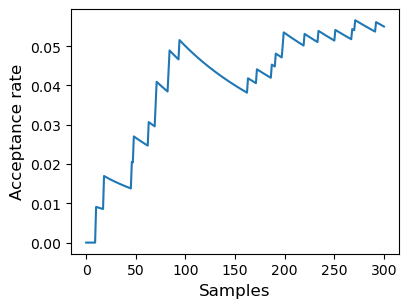

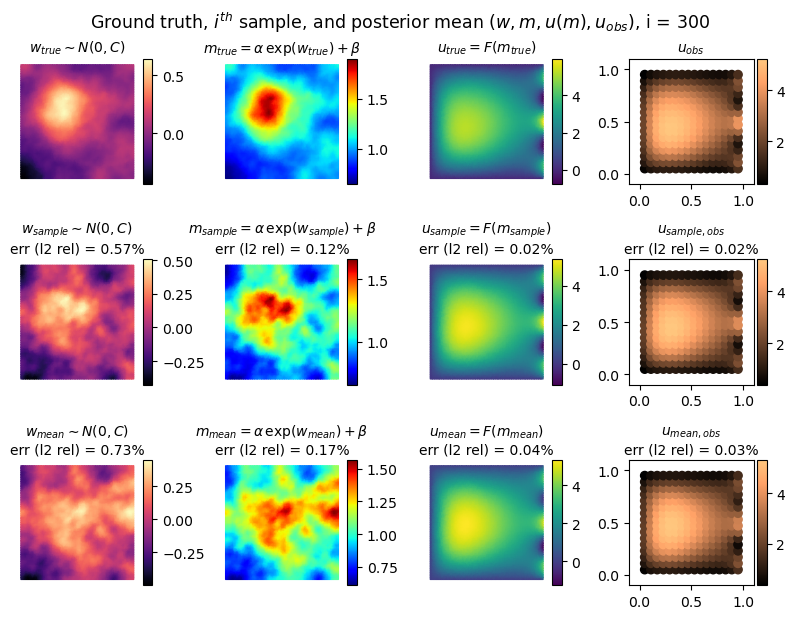

--------------------------------------------------
Sample:  500, Accepted samples:   23, Acceptance Rate: 4.600e-02, Cost mean: 5.047e+01. 
Tracing 100 samples took 2.756e+01s
Error (%) in w: ||w - w_mean|| = 6.620e+01, ||w - w_sample|| = 5.779e+01
Error (%) in m: ||m - m_mean|| = 1.482e+01, ||m - m_sample|| = 1.225e+01
Error (%) in u: ||u - u_mean|| = 3.135e+00, ||u - u_sample|| = 2.285e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.438e+00, ||u_obs - u_obs_sample|| = 1.828e+00
--------------------------------------------------
--------------------------------------------------
Sample:  600, Accepted samples:   23, Acceptance Rate: 3.833e-02, Cost mean: 4.441e+01. 
Tracing 100 samples took 2.624e+01s
Error (%) in w: ||w - w_mean|| = 6.283e+01, ||w - w_sample|| = 5.779e+01
Error (%) in m: ||m - m_mean|| = 1.399e+01, ||m - m_sample|| = 1.225e+01
Error (%) in u: ||u - u_mean|| = 2.878e+00, ||u - u_sample|| = 2.285e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.254e+00, ||u_obs - 

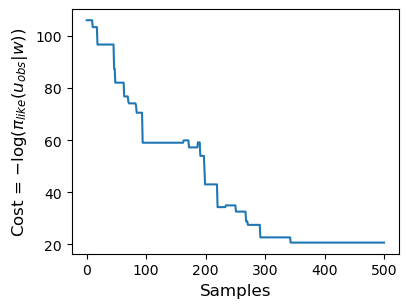

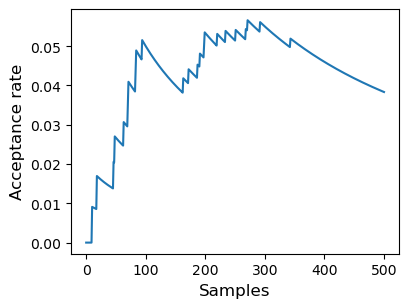

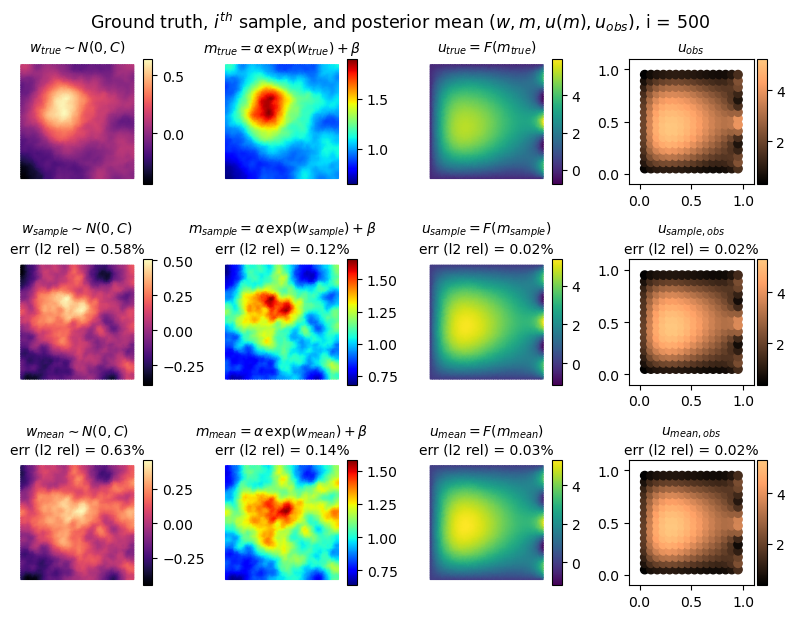

--------------------------------------------------
Sample:  700, Accepted samples:   23, Acceptance Rate: 3.286e-02, Cost mean: 4.040e+01. 
Tracing 100 samples took 2.924e+01s
Error (%) in w: ||w - w_mean|| = 6.101e+01, ||w - w_sample|| = 5.779e+01
Error (%) in m: ||m - m_mean|| = 1.352e+01, ||m - m_sample|| = 1.225e+01
Error (%) in u: ||u - u_mean|| = 2.723e+00, ||u - u_sample|| = 2.285e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.144e+00, ||u_obs - u_obs_sample|| = 1.828e+00
--------------------------------------------------
--------------------------------------------------
Sample:  800, Accepted samples:   23, Acceptance Rate: 2.875e-02, Cost mean: 3.755e+01. 
Tracing 100 samples took 2.613e+01s
Error (%) in w: ||w - w_mean|| = 5.993e+01, ||w - w_sample|| = 5.779e+01
Error (%) in m: ||m - m_mean|| = 1.322e+01, ||m - m_sample|| = 1.225e+01
Error (%) in u: ||u - u_mean|| = 2.623e+00, ||u - u_sample|| = 2.285e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.073e+00, ||u_obs - 

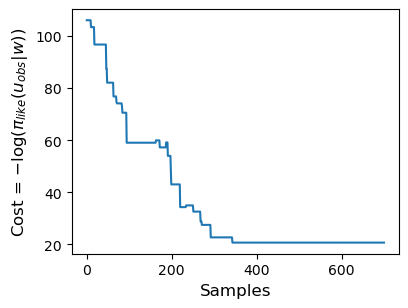

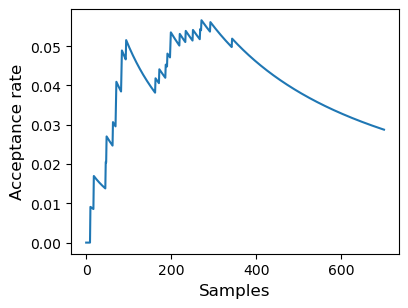

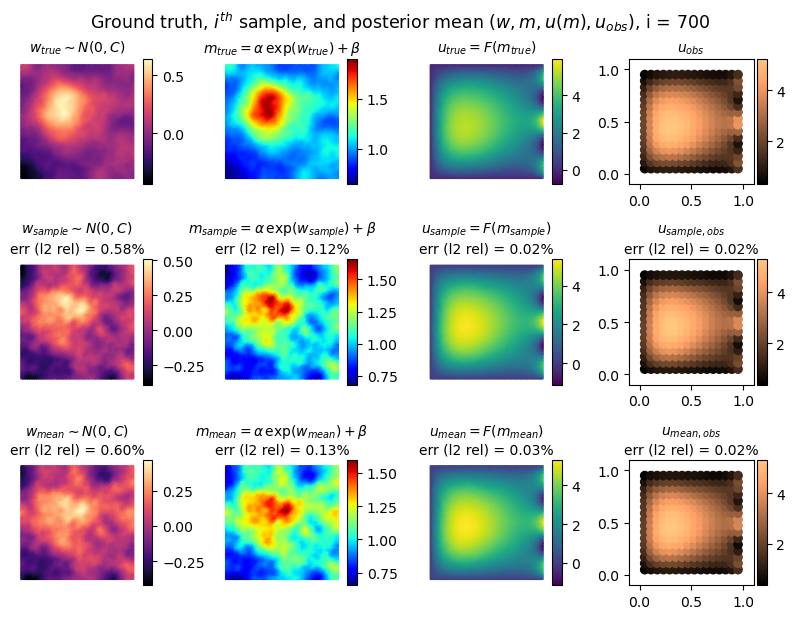

--------------------------------------------------
Sample:  900, Accepted samples:   23, Acceptance Rate: 2.556e-02, Cost mean: 3.542e+01. 
Tracing 100 samples took 2.876e+01s
Error (%) in w: ||w - w_mean|| = 5.926e+01, ||w - w_sample|| = 5.779e+01
Error (%) in m: ||m - m_mean|| = 1.303e+01, ||m - m_sample|| = 1.225e+01
Error (%) in u: ||u - u_mean|| = 2.554e+00, ||u - u_sample|| = 2.285e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.025e+00, ||u_obs - u_obs_sample|| = 1.828e+00
--------------------------------------------------
--------------------------------------------------
Sample: 1000, Accepted samples:   27, Acceptance Rate: 2.700e-02, Cost mean: 3.378e+01. 
Tracing 100 samples took 2.397e+01s
Error (%) in w: ||w - w_mean|| = 5.863e+01, ||w - w_sample|| = 4.984e+01
Error (%) in m: ||m - m_mean|| = 1.284e+01, ||m - m_sample|| = 1.031e+01
Error (%) in u: ||u - u_mean|| = 2.504e+00, ||u - u_sample|| = 2.208e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.985e+00, ||u_obs - 

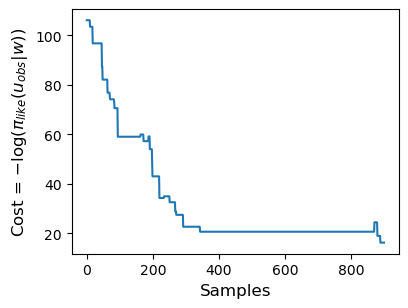

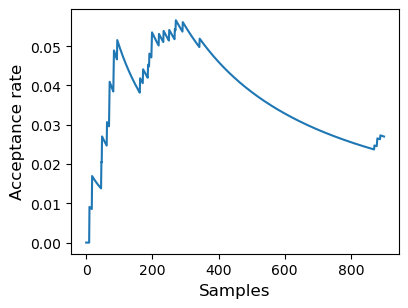

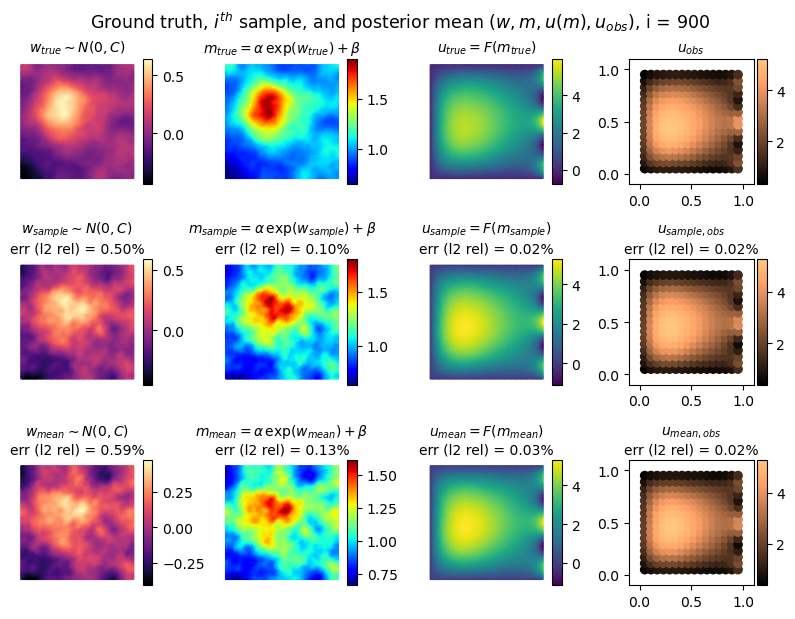

--------------------------------------------------
MCMC finished in 2.959e+02s. 
Total samples: 1100, Accepted samples:   28, Acceptance Rate: 2.545e-02, Cost mean: 3.202e+01
--------------------------------------------------


In [15]:
mcmc.surrogate_to_use = 'DeepONet'

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         savepath = savepath, init_tracer = True)

### PCANet

--------------------------------------------------
MCMC started with 1000 samples and 100 burnin
PCN beta: 2.000e-01, sigma_noise: 1.393e-01
Model used for solving the forward problem: PCANet
Tracer save path: test_mcmc_results_n_samples_1000_n_burnin_100_pcn_beta_0.200_sigma_1.393e-01_surrogate_PCANet
Tracer save filename: tracer
--------------------------------------------------
initializing the current state. Initial cost: 8.673e+02
--------------------------------------------------
Burnin:    0, Cost: 3.032e+02
--------------------------------------------------
--------------------------------------------------
Sample:  100, Accepted samples:    0, Acceptance Rate: 0.000e+00, Cost mean: 0.000e+00. 
Tracing 100 samples took 9.982e+00s
Error (%) in w: ||w - w_mean|| = 1.000e+02, ||w - w_sample|| = 1.000e+02
Error (%) in m: ||m - m_mean|| = 2.244e+01, ||m - m_sample|| = 2.244e+01
Error (%) in u: ||u - u_mean|| = 5.482e+00, ||u - u_sample|| = 5.482e+00
Error (%) in u_obs: ||u_obs - u_o

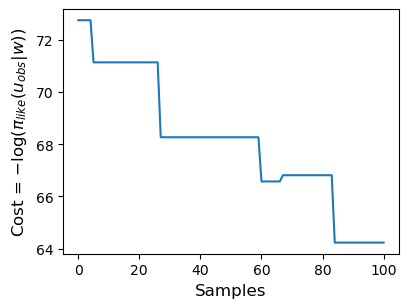

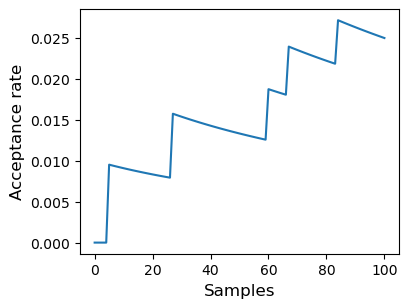

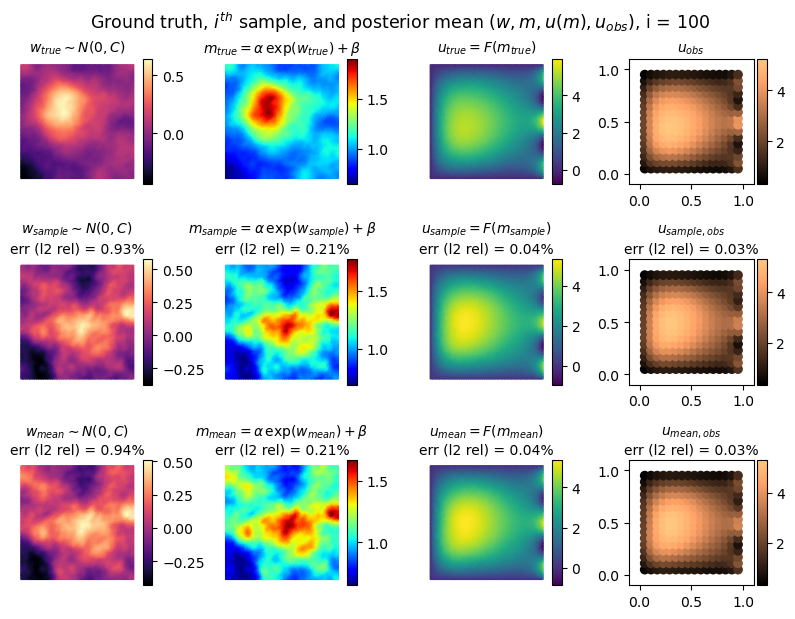

--------------------------------------------------
Sample:  300, Accepted samples:    9, Acceptance Rate: 3.000e-02, Cost mean: 6.368e+01. 
Tracing 100 samples took 1.282e+01s
Error (%) in w: ||w - w_mean|| = 8.839e+01, ||w - w_sample|| = 8.201e+01
Error (%) in m: ||m - m_mean|| = 2.012e+01, ||m - m_sample|| = 1.835e+01
Error (%) in u: ||u - u_mean|| = 3.471e+00, ||u - u_sample|| = 3.362e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.842e+00, ||u_obs - u_obs_sample|| = 2.747e+00
--------------------------------------------------
--------------------------------------------------
Sample:  400, Accepted samples:   14, Acceptance Rate: 3.500e-02, Cost mean: 5.671e+01. 
Tracing 100 samples took 9.903e+00s
Error (%) in w: ||w - w_mean|| = 8.431e+01, ||w - w_sample|| = 7.306e+01
Error (%) in m: ||m - m_mean|| = 1.916e+01, ||m - m_sample|| = 1.680e+01
Error (%) in u: ||u - u_mean|| = 3.143e+00, ||u - u_sample|| = 2.353e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.601e+00, ||u_obs - 

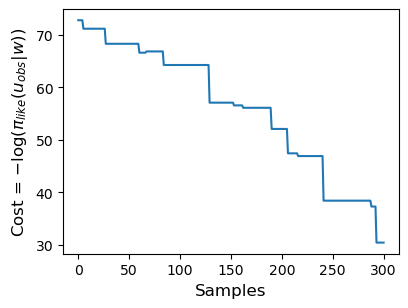

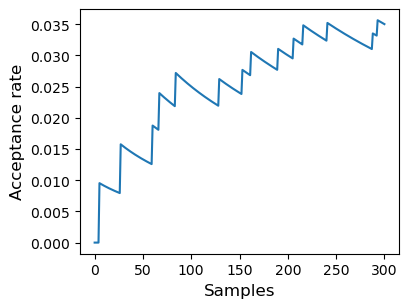

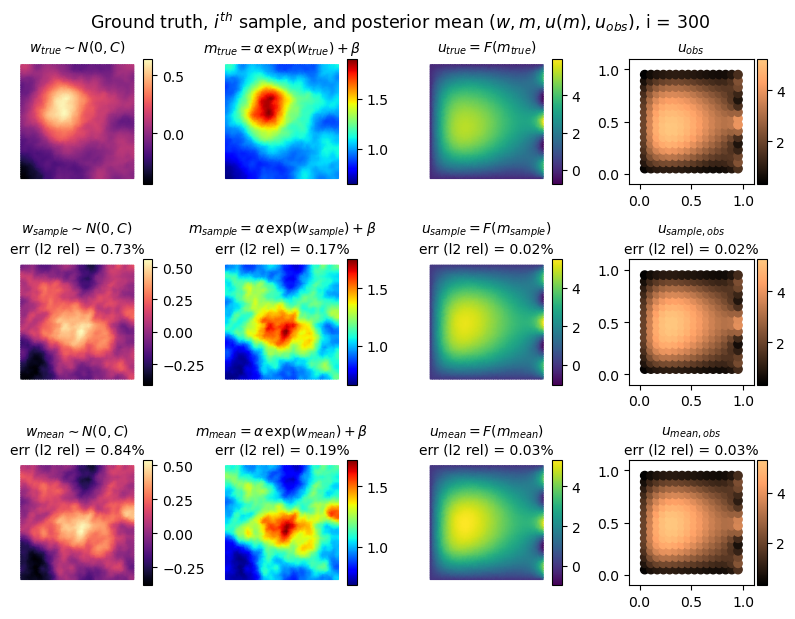

--------------------------------------------------
Sample:  500, Accepted samples:   17, Acceptance Rate: 3.400e-02, Cost mean: 4.921e+01. 
Tracing 100 samples took 1.327e+01s
Error (%) in w: ||w - w_mean|| = 7.867e+01, ||w - w_sample|| = 6.476e+01
Error (%) in m: ||m - m_mean|| = 1.796e+01, ||m - m_sample|| = 1.486e+01
Error (%) in u: ||u - u_mean|| = 2.750e+00, ||u - u_sample|| = 2.171e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.330e+00, ||u_obs - u_obs_sample|| = 1.913e+00
--------------------------------------------------
--------------------------------------------------
Sample:  600, Accepted samples:   20, Acceptance Rate: 3.333e-02, Cost mean: 4.471e+01. 
Tracing 100 samples took 9.875e+00s
Error (%) in w: ||w - w_mean|| = 7.401e+01, ||w - w_sample|| = 6.911e+01
Error (%) in m: ||m - m_mean|| = 1.697e+01, ||m - m_sample|| = 1.567e+01
Error (%) in u: ||u - u_mean|| = 2.503e+00, ||u - u_sample|| = 2.477e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.148e+00, ||u_obs - 

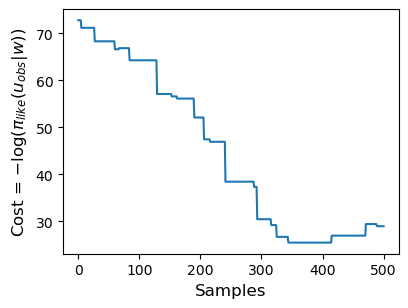

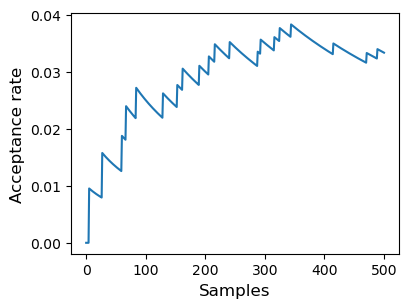

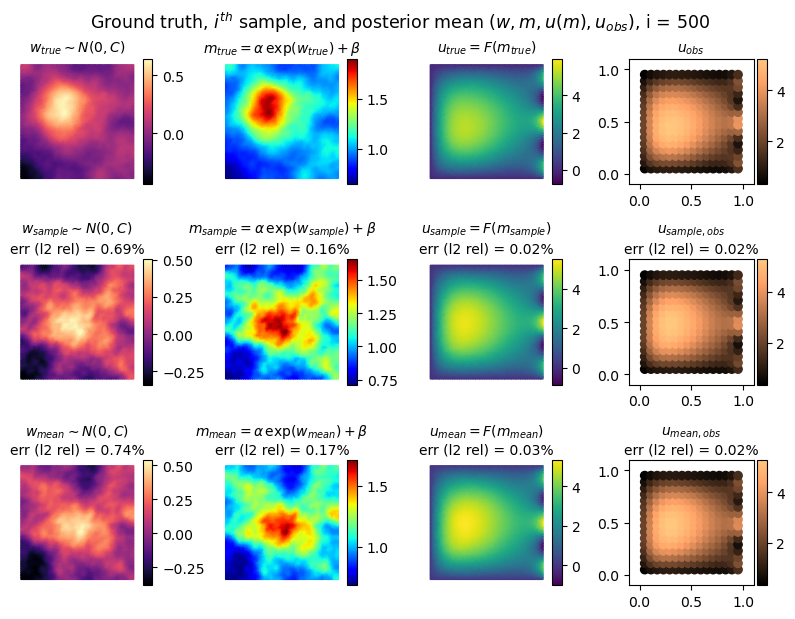

--------------------------------------------------
Sample:  700, Accepted samples:   26, Acceptance Rate: 3.714e-02, Cost mean: 4.176e+01. 
Tracing 100 samples took 1.331e+01s
Error (%) in w: ||w - w_mean|| = 7.136e+01, ||w - w_sample|| = 6.611e+01
Error (%) in m: ||m - m_mean|| = 1.641e+01, ||m - m_sample|| = 1.507e+01
Error (%) in u: ||u - u_mean|| = 2.347e+00, ||u - u_sample|| = 2.295e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 2.028e+00, ||u_obs - u_obs_sample|| = 1.996e+00
--------------------------------------------------
--------------------------------------------------
Sample:  800, Accepted samples:   27, Acceptance Rate: 3.375e-02, Cost mean: 3.913e+01. 
Tracing 100 samples took 9.901e+00s
Error (%) in w: ||w - w_mean|| = 6.916e+01, ||w - w_sample|| = 6.469e+01
Error (%) in m: ||m - m_mean|| = 1.596e+01, ||m - m_sample|| = 1.470e+01
Error (%) in u: ||u - u_mean|| = 2.226e+00, ||u - u_sample|| = 2.000e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.946e+00, ||u_obs - 

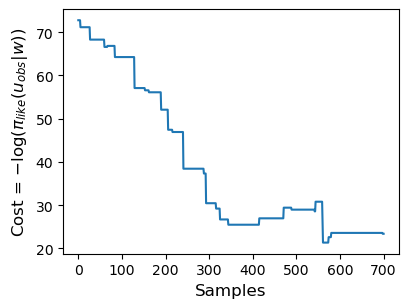

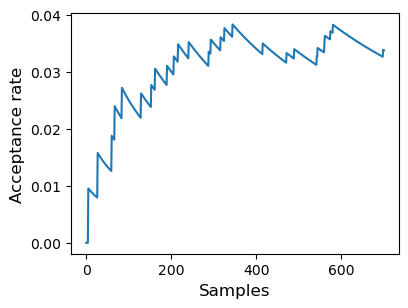

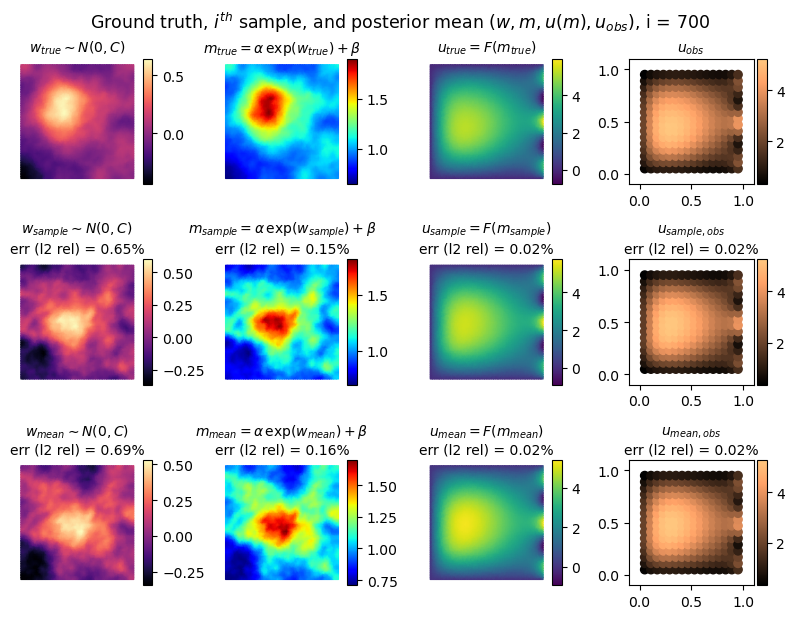

--------------------------------------------------
Sample:  900, Accepted samples:   27, Acceptance Rate: 3.000e-02, Cost mean: 3.714e+01. 
Tracing 100 samples took 1.357e+01s
Error (%) in w: ||w - w_mean|| = 6.763e+01, ||w - w_sample|| = 6.469e+01
Error (%) in m: ||m - m_mean|| = 1.562e+01, ||m - m_sample|| = 1.470e+01
Error (%) in u: ||u - u_mean|| = 2.140e+00, ||u - u_sample|| = 2.000e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.892e+00, ||u_obs - u_obs_sample|| = 1.895e+00
--------------------------------------------------
--------------------------------------------------
Sample: 1000, Accepted samples:   28, Acceptance Rate: 2.800e-02, Cost mean: 3.561e+01. 
Tracing 100 samples took 1.019e+01s
Error (%) in w: ||w - w_mean|| = 6.647e+01, ||w - w_sample|| = 6.643e+01
Error (%) in m: ||m - m_mean|| = 1.535e+01, ||m - m_sample|| = 1.492e+01
Error (%) in u: ||u - u_mean|| = 2.069e+00, ||u - u_sample|| = 2.073e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.847e+00, ||u_obs - 

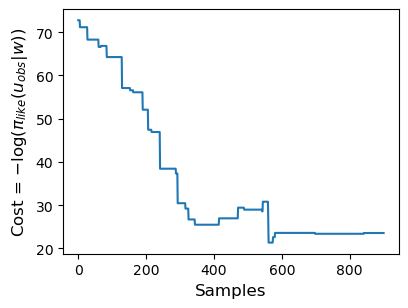

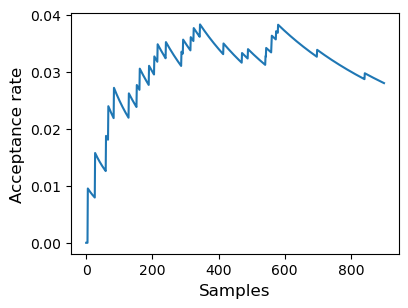

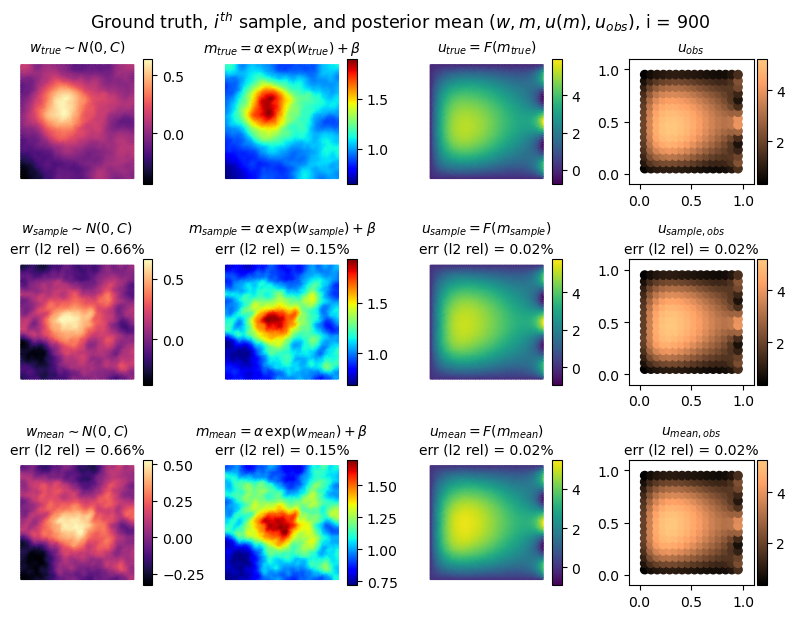

--------------------------------------------------
MCMC finished in 1.262e+02s. 
Total samples: 1100, Accepted samples:   29, Acceptance Rate: 2.636e-02, Cost mean: 3.425e+01
--------------------------------------------------


In [16]:
mcmc.surrogate_to_use = 'PCANet'

if mcmc.surrogate_to_use is not None:
    savepath = savepath_base + '_surrogate_{}/'.format(mcmc.surrogate_to_use)
else:
    savepath = savepath_base + '/'

os.makedirs(savepath, exist_ok = True)

savefilename = 'tracer'

mcmc.run(n_samples = n_samples, n_burnin = n_burnin, \
         pcn_beta = pcn_beta, sigma_noise = sigma_noise, \
         print_every = print_every, print_lvl = 2, \
         display_plot_every = display_plot_every, \
         savefilename = savefilename, \
         savepath = savepath, init_tracer = True)

# Plotting

In [17]:
s = compute_sample_errors(mcmc)
print(s)

Error (%) in w: ||w - w_mean|| = 6.530e+01, ||w - w_sample|| = 6.143e+01
Error (%) in m: ||m - m_mean|| = 1.506e+01, ||m - m_sample|| = 1.374e+01
Error (%) in u: ||u - u_mean|| = 1.994e+00, ||u - u_sample|| = 1.762e+00
Error (%) in u_obs: ||u_obs - u_obs_mean|| = 1.796e+00, ||u_obs - u_obs_sample|| = 1.670e+00


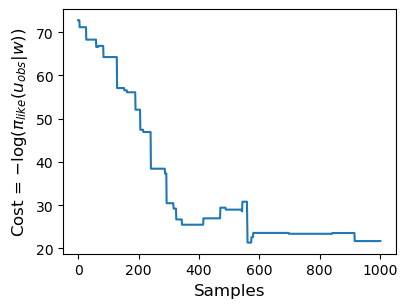

In [19]:
savefig = False
pp_params = mcmc.pp_params['curve_plot']
plot_curve(mcmc.tracer.accepted_samples_cost, xl=r'Samples', \
        yl= r'Cost = $-\log(\pi_{like}(u_{obs} | w))$', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'])

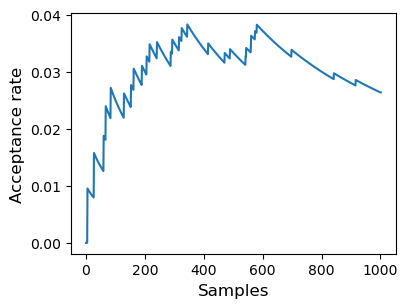

In [20]:
savefig = False
plot_curve(mcmc.tracer.acceptance_rate, xl=r'Samples', \
        yl= r'Acceptance rate', \
        fs = pp_params['fs'], lw = pp_params['lw'], figsize=pp_params['figsize'])

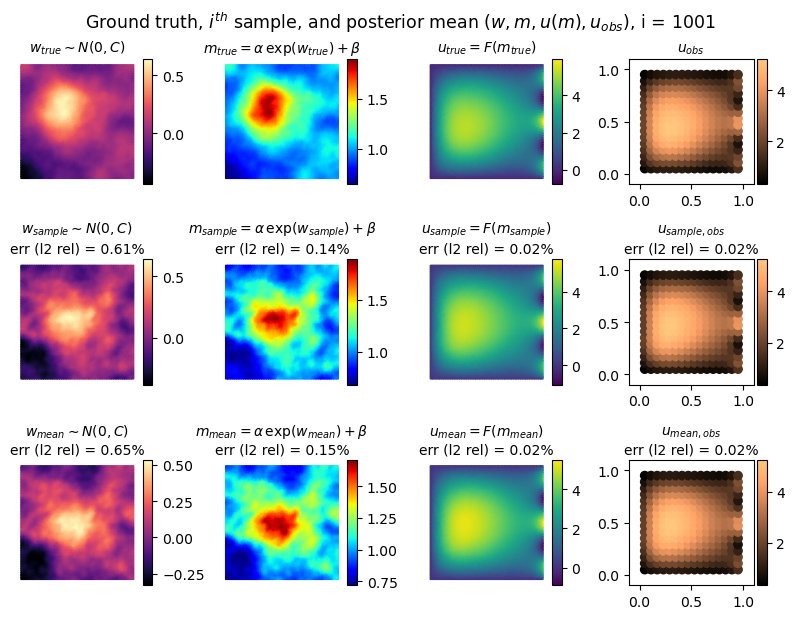

In [23]:
w_mean = mcmc.tracer.accepted_samples_mean_m
w_sample_i = len(mcmc.tracer.accepted_samples_m) - 1
w_sample = mcmc.tracer.accepted_samples_m[w_sample_i]

mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, savefilename = None, params = mcmc.pp_params['field_plot'])

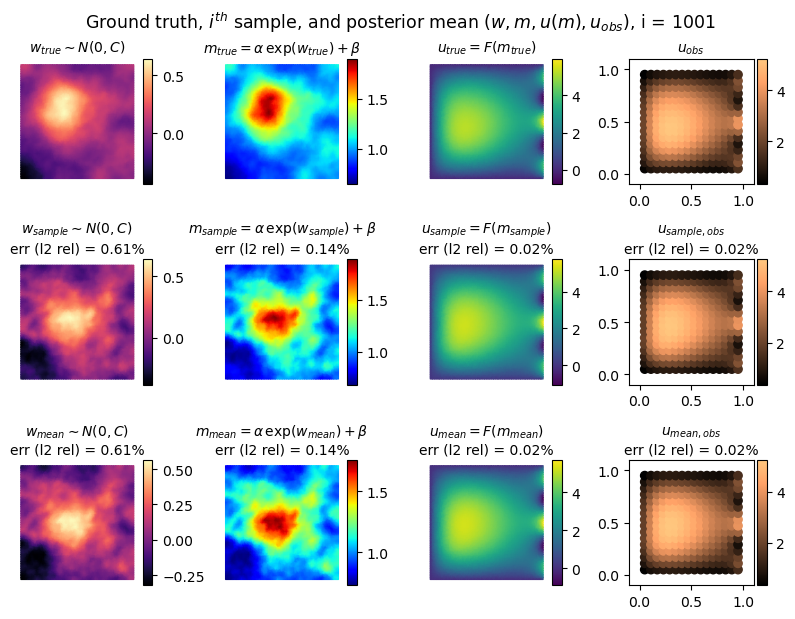

In [24]:
nsamples = len(mcmc.tracer.accepted_samples_m)
ignore_n = int(0.3 * nsamples)
ignore_end_n = int((1. - 0.) * nsamples)
w_mean = np.mean(mcmc.tracer.accepted_samples_m[ignore_n:ignore_end_n, :], axis = 0)
w_sample_i = len(mcmc.tracer.accepted_samples_m) - 1
w_sample = mcmc.tracer.accepted_samples_m[w_sample_i]

save_sf = True
plot_sf = mcmc.tracer.savepath + 'true_and_posterior_mean_w_m_u_remove_{}_samples_iter_{}.png'.format(ignore_n, nsamples)
mcmc_plot_fields_base(w_mean, w_sample, w_sample_i, mcmc, savefilename = plot_sf if save_sf else None, params = mcmc.pp_params['field_plot'])